## AIMD for TCP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

# global totalSR_AIMD,totalSR_HSTCP
# totalSR_AIMD=0.0
# totalSR_HSTCP=0.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def congestion_control_simulation(C:int, x1:int, x2:int, alpha:int, beta:int, maxIterate:int, mode='AIMD', output="congestion_plot.png", title='Congestion Control', x3:int=None):
    """
    Simulates congestion control algorithm (AIMD or LIPD).

    Parameters:
    - C: Constraint value (capacity).
    - alpha: Additive increase step (or base increase parameter for LIPD).
    - beta: Multiplicative decrease factor (or base decrease parameter for LIPD).
    - x1, x2: Initial values of x1 and x2 (congestion window sizes).
    - x3: Optional third congestion window size.
    - mode: Algorithm mode ('AIMD' or 'LIPD').
    - output: Filename for saving the output plot.
    - title: Title of the plot.

    Returns:
    - x1_values, x2_values, x3_values: Arrays containing values over iterations.
    """
    iterations = 1
    optimal_x = (C - 0) / (1 - -1)
    optimal_y = -1 * optimal_x + C
    
    # Arrays to store values
    x1_values = np.array([x1])
    x2_values = np.array([x2])
    x3_values = np.array([x3]) if x3 is not None else None  # Optional x3 values

    def a(w):
        return alpha * np.log(w + 1)  # Logarithmic increase function for HLIPD

    def b(w):
        return beta * (w / (w + 1)) ** 2  # Power decrease function for LIPD
        
    def jains_fairness_index(x1, x2, x3=None):

        # Create list of values including x3 if it's provided
        values = [x for x in [x1, x2, x3] if x is not None]
        
        # Check if all values are valid numbers (either int or float)
        if any(not isinstance(x, (int, float)) for x in values):
            raise ValueError("All arguments must be numbers (int or float), and cannot be None.")
        
        # Number of values
        n = len(values)
        
        # Calculate the sum of values and sum of squares of values
        total = sum(values)
        sum_of_squares = sum(x**2 for x in values)
        
        # Calculate Jain's Fairness Index
        fairness_index = (total ** 2) / (n * sum_of_squares) if n > 0 else 0.0
        
        return fairness_index



    def stability_metrics(sending_rates):
        mean_value = np.mean(sending_rates)
        std_dev = np.std(sending_rates)
        
        # Avoid division by zero
        if mean_value != 0:
            cv = std_dev / mean_value  # Coefficient of Variation
        else:
            cv = float('inf')  # If the mean is 0, the CV is infinite, meaning highly unstable
        
        return mean_value, std_dev, cv

    # Simulation loop
    while not (round(x1, 2) == optimal_x and round(x2, 2) == optimal_y):
        if iterations == maxIterate:
            break
        
        w = x1 + x2 + (x3 if x3 is not None else 0)  # Total sending rate including x3 if provided
        if mode == 'AIMD':
            # Additive Increase / Multiplicative Decrease (AIMD)
            if x1 + x2 + (x3 if x3 is not None else 0) <= C:
                x1 += alpha
                x2 += alpha
                if x3 is not None:
                    x3 += alpha
            else:
                x1 *= beta
                x2 *= beta
                if x3 is not None:
                    x3 *= beta
        elif mode == 'LIPD':
            # Additive Increase / Multiplicative Decrease (LIPD)
            if x1 + x2 + (x3 if x3 is not None else 0) <= C:
                alpha1 = a(w)
                alpha2 = a(w)
                x1 += alpha1
                x2 += alpha2
                if x3 is not None:
                    alpha3 = a(w)
                    x3 += alpha3
            else:
                beta1 = b(w)
                beta2 = b(w)
                x1 *= beta1
                x2 *= beta2
                if x3 is not None:
                    beta3 = b(w)
                    x3 *= beta3
        
        # Store values for plotting
        x1_values = np.append(x1_values, x1)
        x2_values = np.append(x2_values, x2)
        if x3 is not None:
            x3_values = np.append(x3_values, x3)

        iterations += 1

    sendingrate_x1 = np.mean(x1_values)
    sendingrate_x2 = np.mean(x2_values)
    sendingrate_x3 = np.mean(x3_values) if x3 is not None else 0
    print('Number of iterations to converge: ', iterations)
    
    # Plotting the results
    fig, (plot1, plot2, plot3) = plt.subplots(3, 1, figsize=(12, 14))
    plt.subplots_adjust(hspace=0.5)

    plot1.plot(x1_values, x2_values, '-o', label=f'{mode} Iterates', linewidth=1.5)
    x = np.linspace(0, C*1.1, C)
    plot1.plot(x, C - x, 'r--', linewidth=2, label='Line (C,0) to (0,C)')
    plot1.plot(x, x, 'g--', linewidth=1.5, label='Efficiency Line')
    plot1.set_xlabel('x1')
    plot1.set_ylabel('x2')
    plot1.set_title(title)
    plot1.legend()
    plot1.grid(True)
    plot1.set_xlim(0, C*1.2)
    plot1.set_ylim(0, C*1.2)

    # Congestion Window plot for x1
    rtt_values = np.linspace(0, iterations, iterations)
    plot2.plot(rtt_values, x1_values, marker=".", color='black', linewidth=1)
    plot2.set_xlabel('Number of Transmissions (RTTs)')
    plot2.set_ylabel('Congestion Window Size\n(Segments)')
    plot2.set_title(f'Congestion Window for $x_{{1}}$')
    plot2.set_xlim(0, iterations * 1.1)
    plot2.annotate(f'Sending Rate $x_{{1}}$: {sendingrate_x1:.2f} segment / RTT', xy=(iterations / 2, C / 8))
    plot2.grid(False)

    # Congestion Window plot for x2
    plot3.plot(rtt_values, x2_values, marker=".", color='black', linewidth=1)
    plot3.set_xlabel('Number of Transmissions (RTTs)')
    plot3.set_ylabel('Congestion Window Size\n(Segments)')
    plot3.set_title(f'Congestion Window for $x_{{2}}$')
    plot3.set_xlim(0, iterations * 1.1)
    plot3.annotate(f'Sending Rate $x_{{2}}$: {sendingrate_x2:.2f} segment / RTT', xy=(iterations / 2, C / 1.8))
    plot3.grid(False)

    if x3 is not None:
        # Create a separate plot for x3
        fig_x3, plot4 = plt.subplots(figsize=(12, 6))
        plot4.plot(rtt_values, x3_values, marker=".", color='red', linewidth=1)
        plot4.set_xlabel('Number of Transmissions (RTTs)')
        plot4.set_ylabel('Congestion Window for $x_{{3}}$')
        plot4.set_title(f'Congestion Window for $x_{{3}}$')
        plot4.set_xlim(0, iterations * 1.1)
        plot4.annotate(f'Sending Rate $x_{{3}}$: {sendingrate_x3:.2f} segment / RTT', xy=(iterations / 2, C / 2))
        plot4.grid(False)
        fig_x3.suptitle(title)

    total_sending_rate = sendingrate_x1 + sendingrate_x2 + sendingrate_x3
    print(f'Total Sending Rate: {total_sending_rate:.2f} segment / RTT')
    
    fairness = jains_fairness_index(x1, x2, x3)
    print(f"Jain's Fairness Index: {fairness:.4f}")

    # Stability metrics
    algo_sending_rates = [sendingrate_x1, sendingrate_x2, sendingrate_x3] if x3 is not None else [sendingrate_x1, sendingrate_x2]
    mean, std, cv = stability_metrics(algo_sending_rates)
    print(f"Stability - Mean Sending Rate: {mean:.2f}, Std Dev: {std:.2f}, CV: {cv:.2f}")

    fig.suptitle(title)
    plt.savefig(output)
    plt.show()


Number of iterations to converge:  205
Total Sending Rate: 45.26 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 22.63, Std Dev: 1.73, CV: 0.08


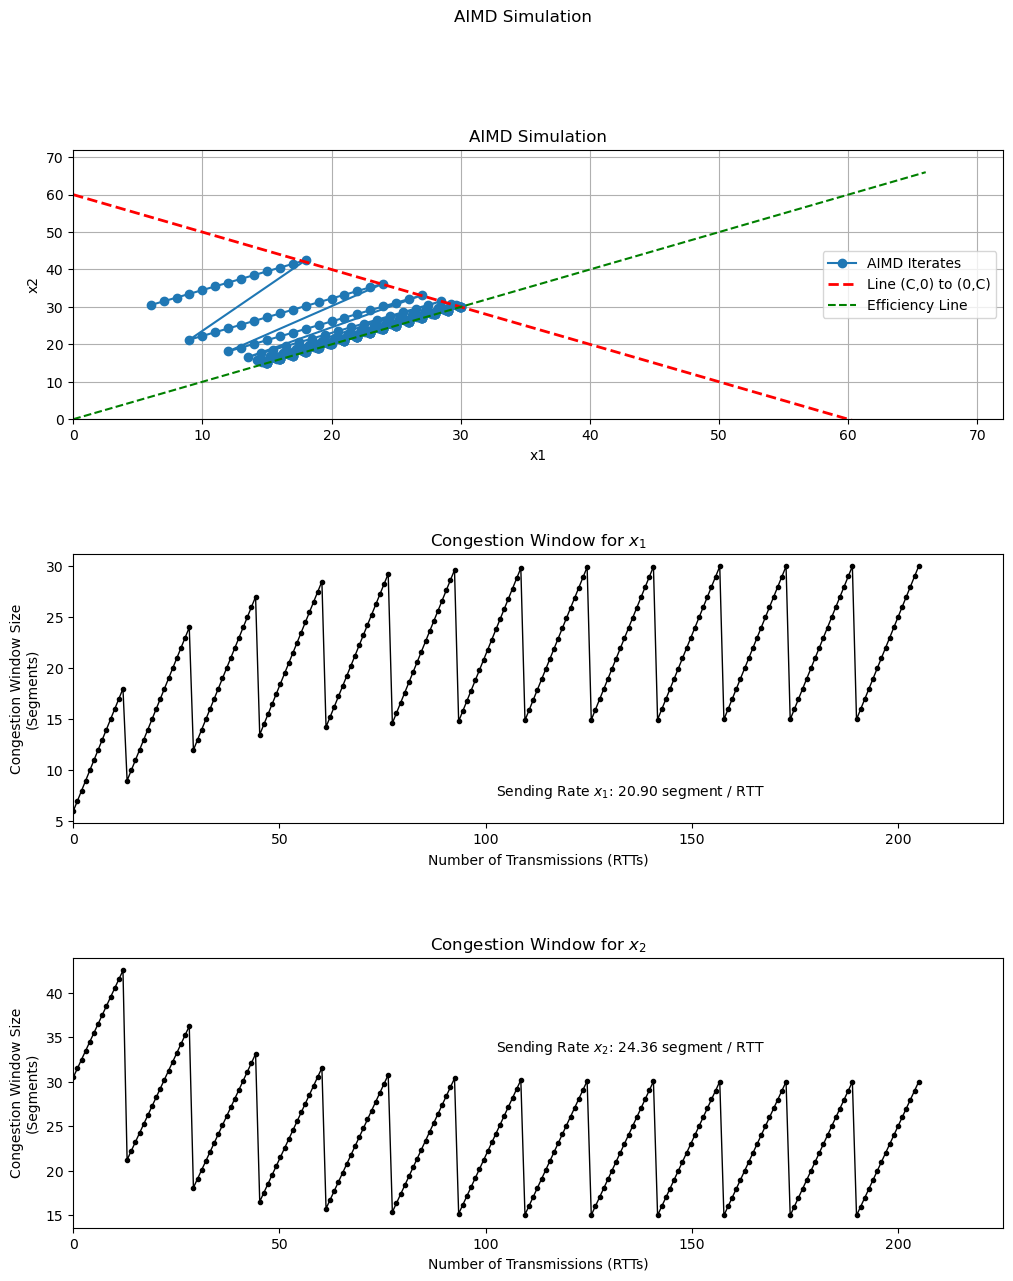

In [3]:

# aimd_simulation(
#           C=60,
#           x1=6,
#           x2=30.5,
#           alpha=1,
#           beta=0.5,
#           title="Standard TCP AIMD Algorithm"
#           )
congestion_control_simulation(C=60, x1=6, x2=30.5, alpha=1, beta=0.5, maxIterate=1000, mode='AIMD', output='aimd_results.png', title='AIMD Simulation')

# aimd_simulation(
#           C=50,
#           x1=2,
#           x2=12,
#           alpha=1,
#           beta=0.5,
#           title="Standard TCP AIMD Algorithm"
#           )

# congestion_control_simulation(C=50, x1=2, x2=12, alpha=1, beta=0.5, maxIterate=1000, mode='AIMD', output='aimd_results.png', title='AIMD Simulation')



Number of iterations to converge:  205
Total Sending Rate: 46.51 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 23.26, Std Dev: 0.59, CV: 0.03


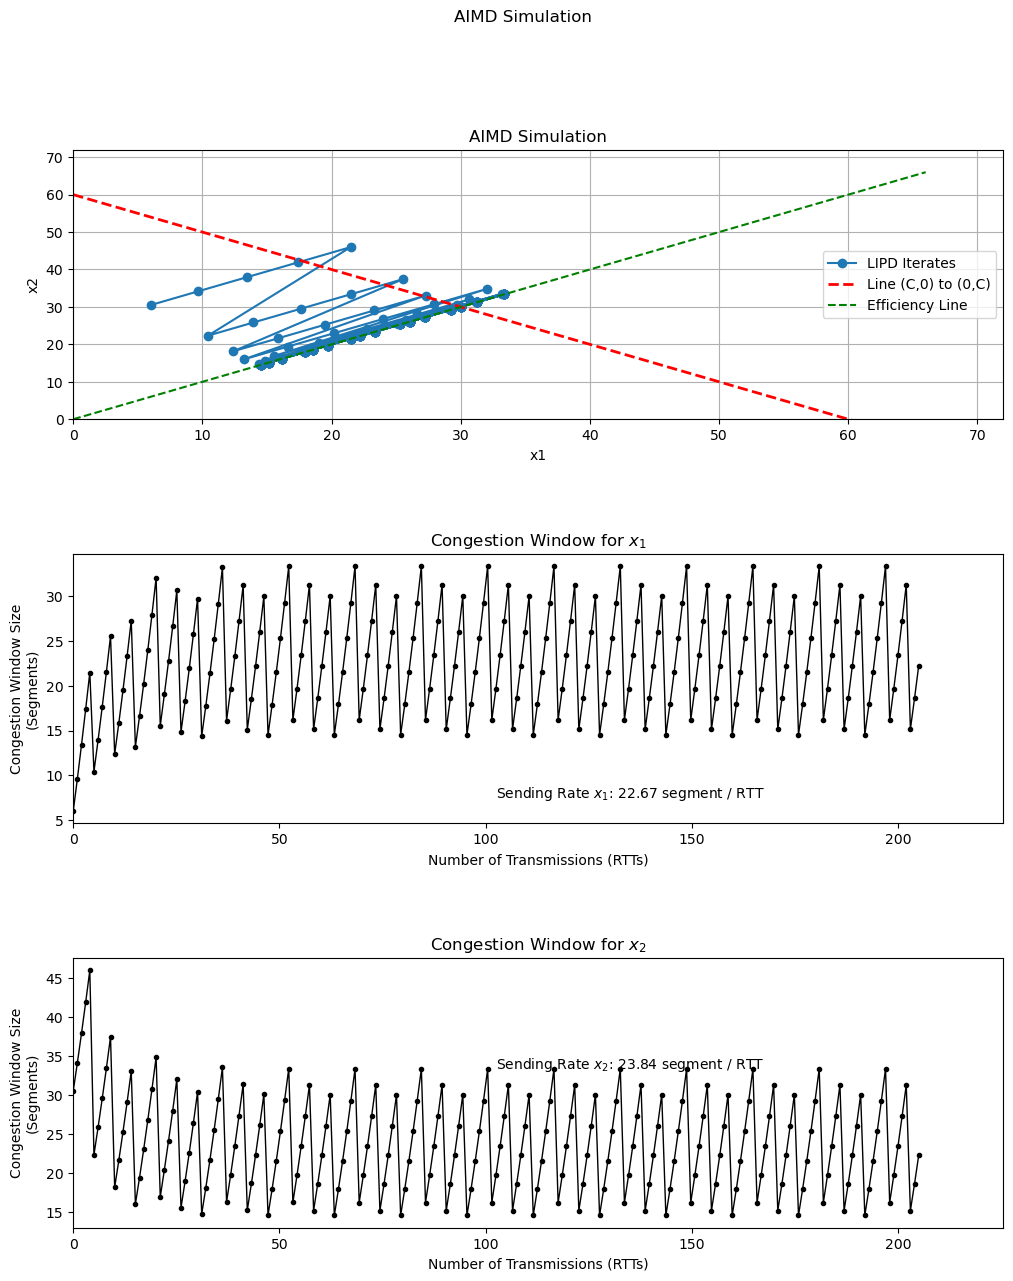

In [4]:
# current_time = datetime.datetime.now()
# formatted_time = current_time.strftime("%Y-%m-%d_%H-%M-%S")

# highspeed_tcp_sim(
#           C=60,
#           x1=6,
#           x2=30.5,
#           alpha=1,
#           beta=0.5,
#           output=f"aimd_{formatted_time}.svg",
#           title="Standard TCP AIMD Algorithm"
#           )

congestion_control_simulation(C=60, x1=6, x2=30.5, alpha=1, beta=0.5, maxIterate=205, mode='LIPD', output='aimd_results.png', title='AIMD Simulation')


### Compare throughput (with C=205)

AIMD: 45.26 segments / RTT

High-Speed TCP: 46.51 segments / RTT

**High-Speed TCP has better throughput**

### Compare convergence time (count iterations to reach convergence)

AIMD: 205 iterations

High-Speed TCP: 1000 or more /iterations

**AIMD has better convergence time**

### Compare fairness (with C=205)

AIMD: 1.00

High-Speed TCP: 1.00

**Both are equally fair**

### Compare stability (with C=205)

AIMD coefficient of variation = std/mean = 0.08

High-Speed TCP coefficient of variation = std/mean = 0.03

**High Speed TCP has slightly better stability**

Number of iterations to converge:  500
Total Sending Rate: 323.62 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 161.81, Std Dev: 4.29, CV: 0.03


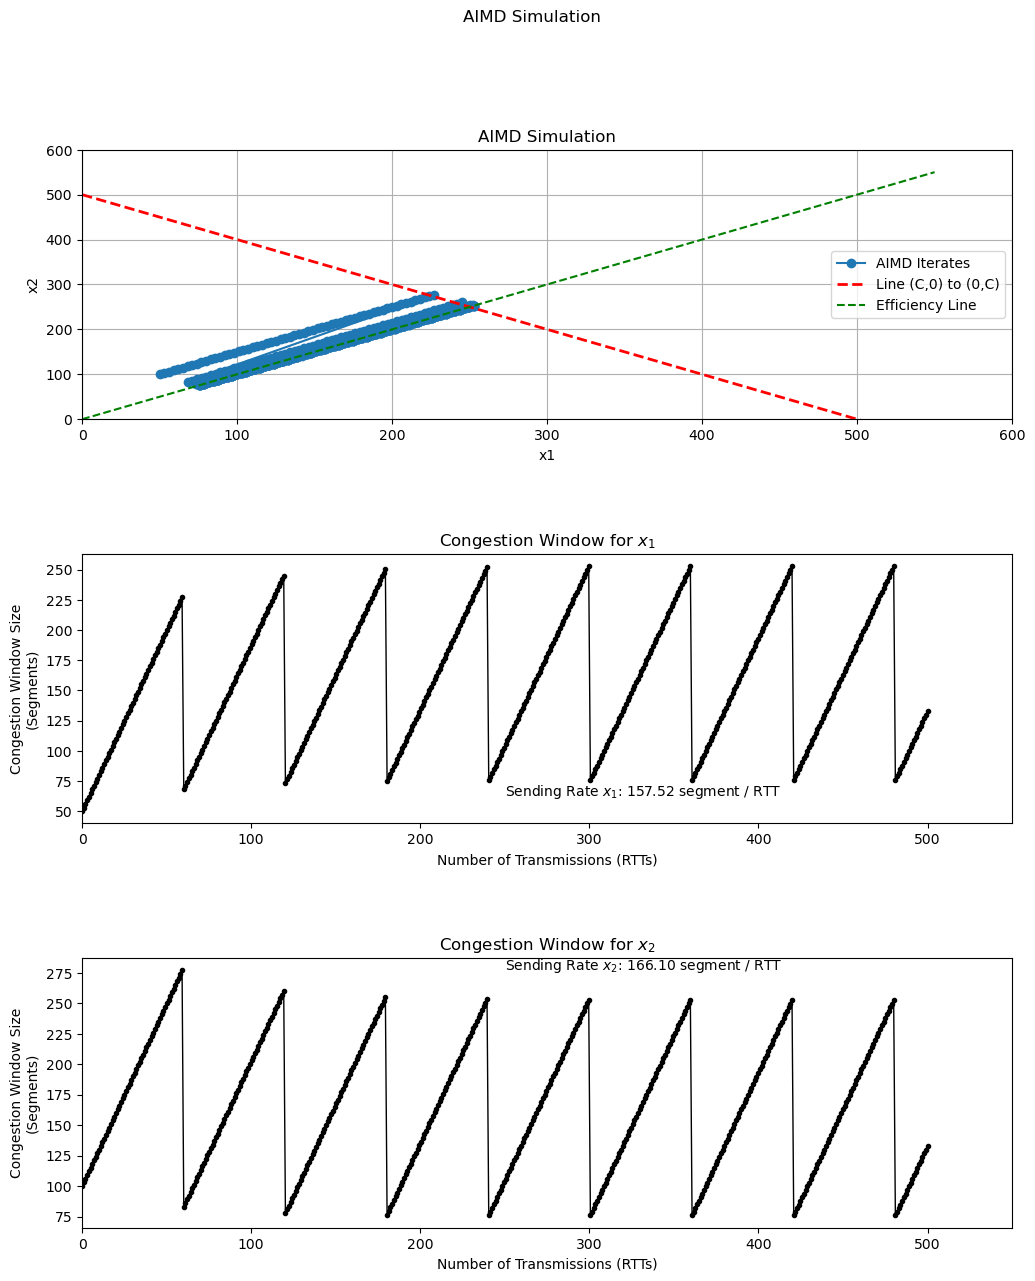

In [5]:
congestion_control_simulation(C=500, x1=50, x2=100, alpha=3, beta=0.3, maxIterate=500, mode='AIMD', output='aimd_results.png', title='AIMD Simulation')


Number of iterations to converge:  500
Total Sending Rate: 331.04 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 165.52, Std Dev: 0.85, CV: 0.01


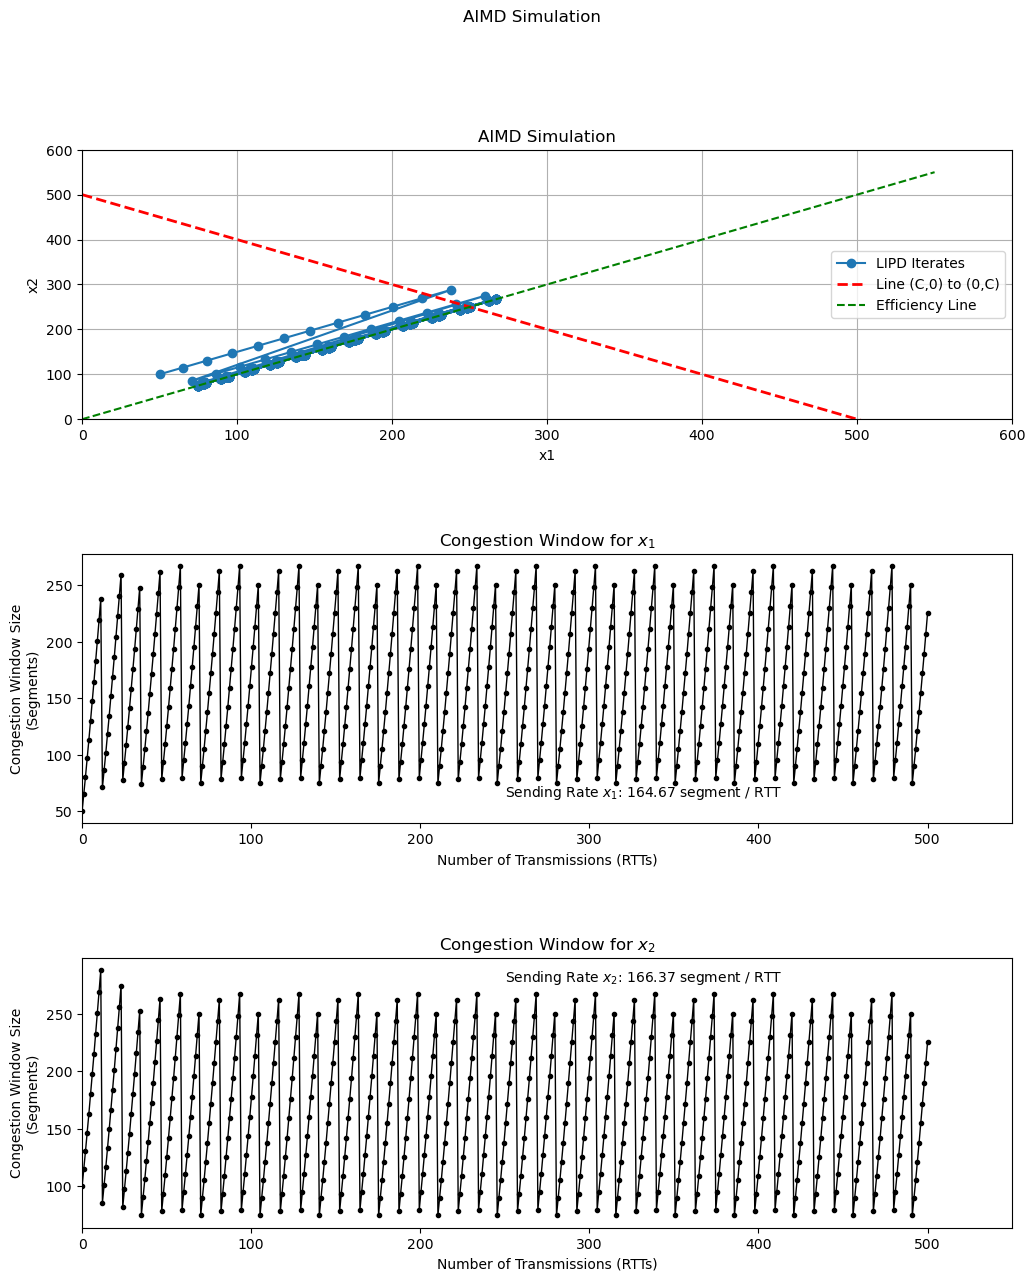

In [6]:
congestion_control_simulation(C=500, x1=50, x2=100, alpha=3, beta=0.3, maxIterate=500, mode='LIPD', output='aimd_results.png', title='AIMD Simulation')


Number of iterations to converge:  300
Total Sending Rate: 555.00 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 277.50, Std Dev: 9.89, CV: 0.04


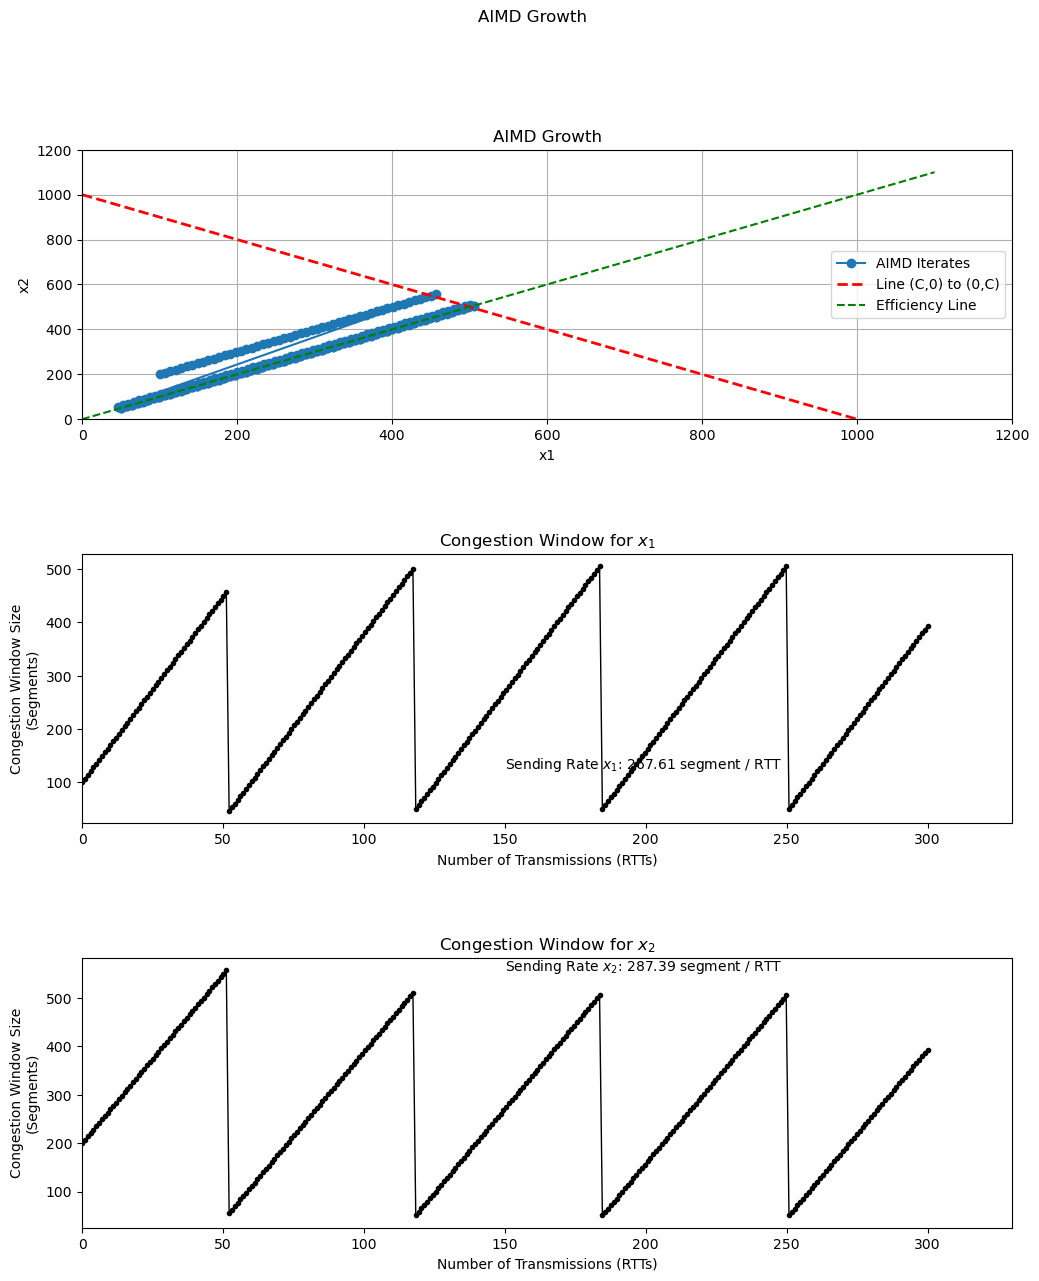

In [7]:
congestion_control_simulation(
    C=1000,  
    x1=100,  
    x2=200,  
    alpha=7,  
    beta=0.1,  
    maxIterate=300,  
    # mode='LIPD',  
    mode='AIMD',
    output='aimd.png',  
    title='AIMD Growth'
)

Number of iterations to converge:  300
Total Sending Rate: 539.06 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 269.53, Std Dev: 1.72, CV: 0.01


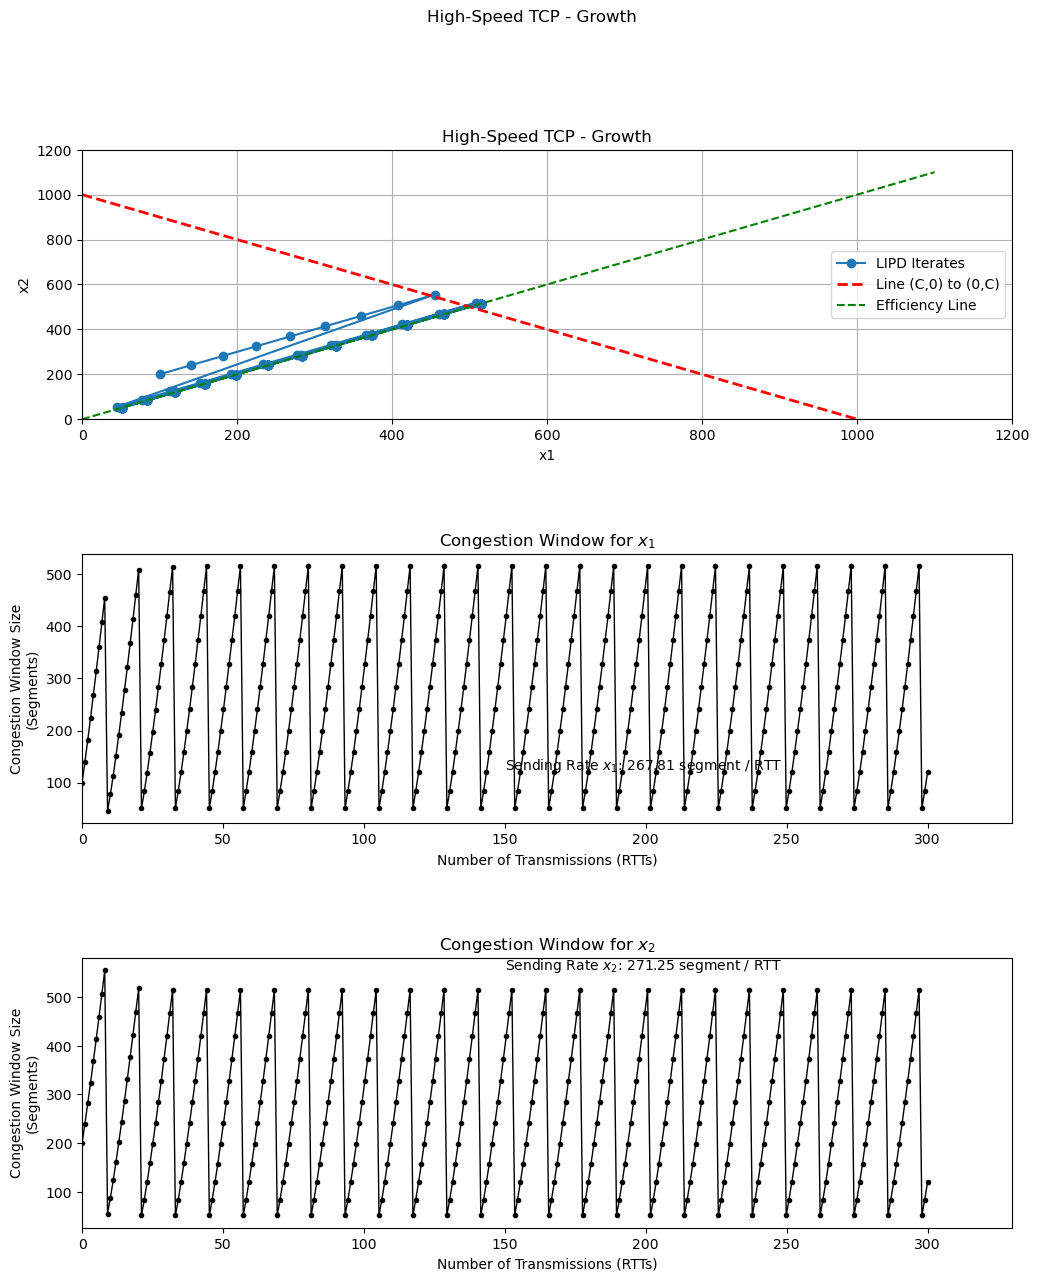

In [8]:
congestion_control_simulation(
    C=1000,  
    x1=100,  
    x2=200,  
    alpha=7,  
    beta=0.1,  
    maxIterate=300,  
    mode='LIPD',  
    # mode='AIMD',
    output='LIPD.png',  
    title='High-Speed TCP - Growth'
)

# compare with one more input (3 input)

Number of iterations to converge:  1000
Total Sending Rate: 38.32 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 12.77, Std Dev: 0.12, CV: 0.01


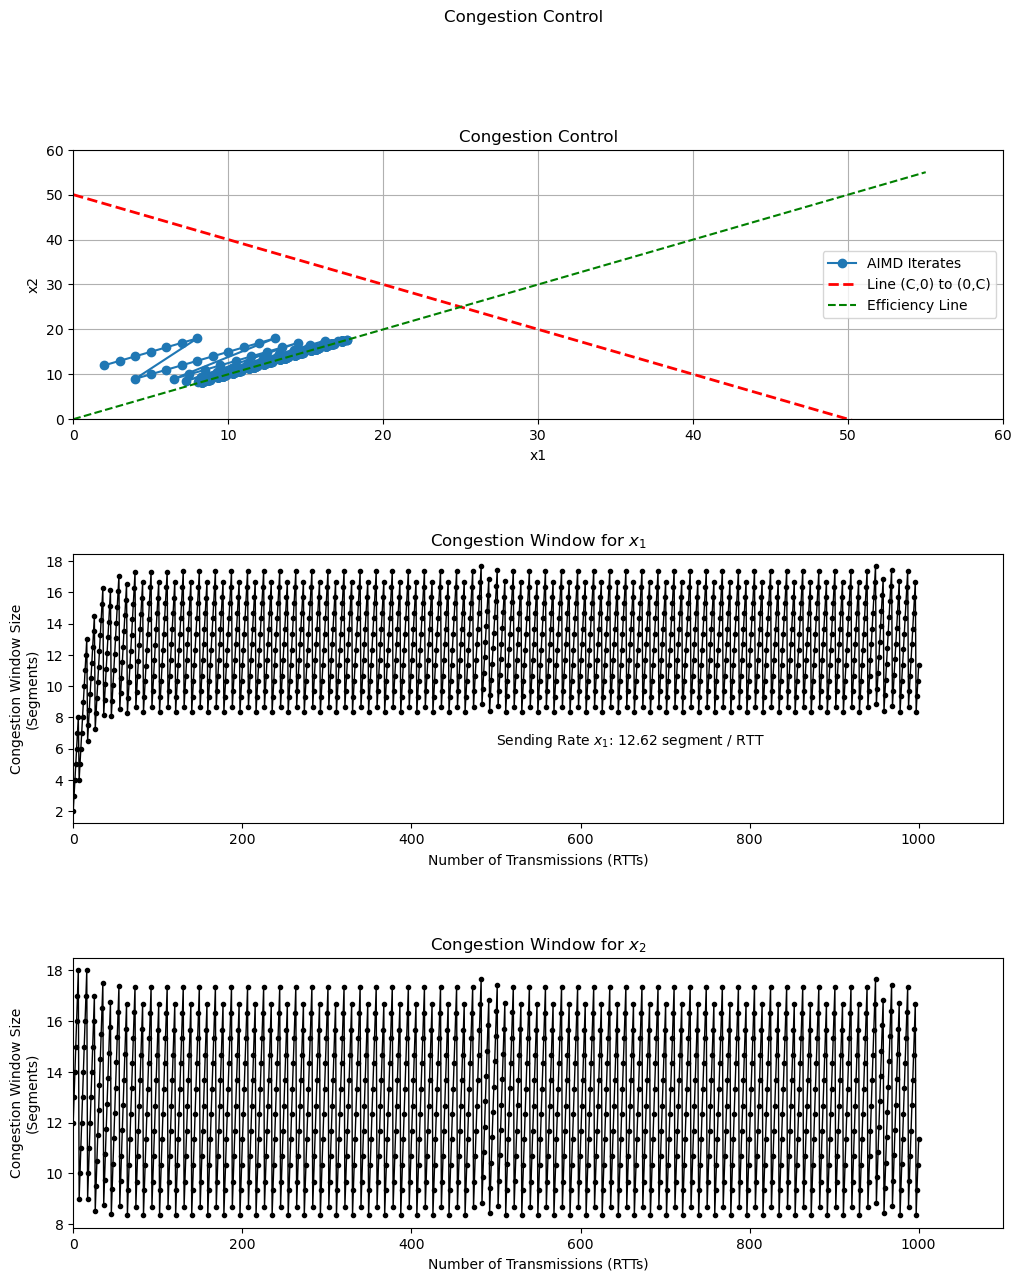

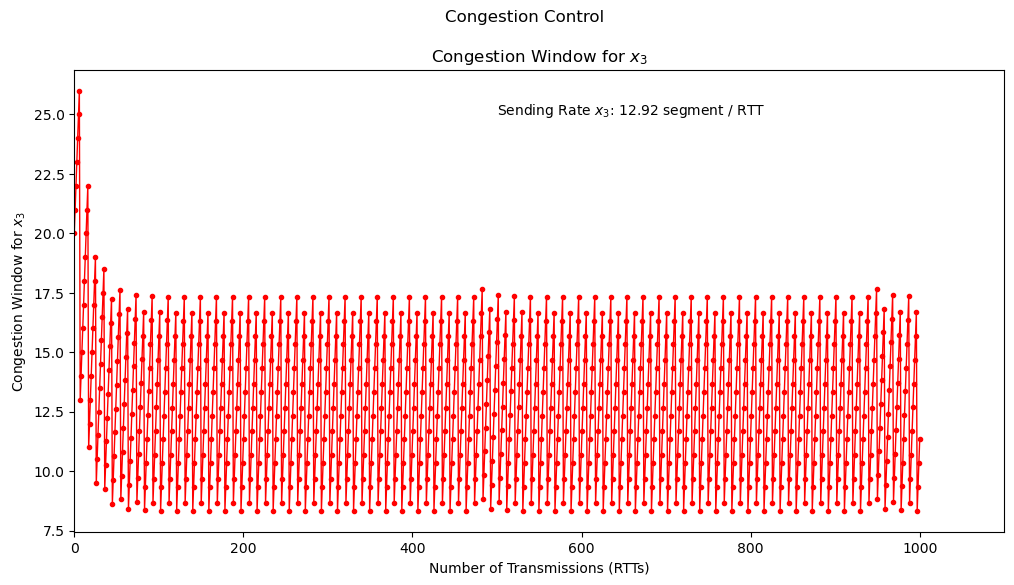

In [9]:
congestion_control_simulation(C=50, x1=2, x2=12, alpha=1, beta=0.5, maxIterate=1000, mode='AIMD', x3=20)


Number of iterations to converge:  1000
Total Sending Rate: 41.01 segment / RTT
Jain's Fairness Index: 1.0000
Stability - Mean Sending Rate: 13.67, Std Dev: 0.05, CV: 0.00


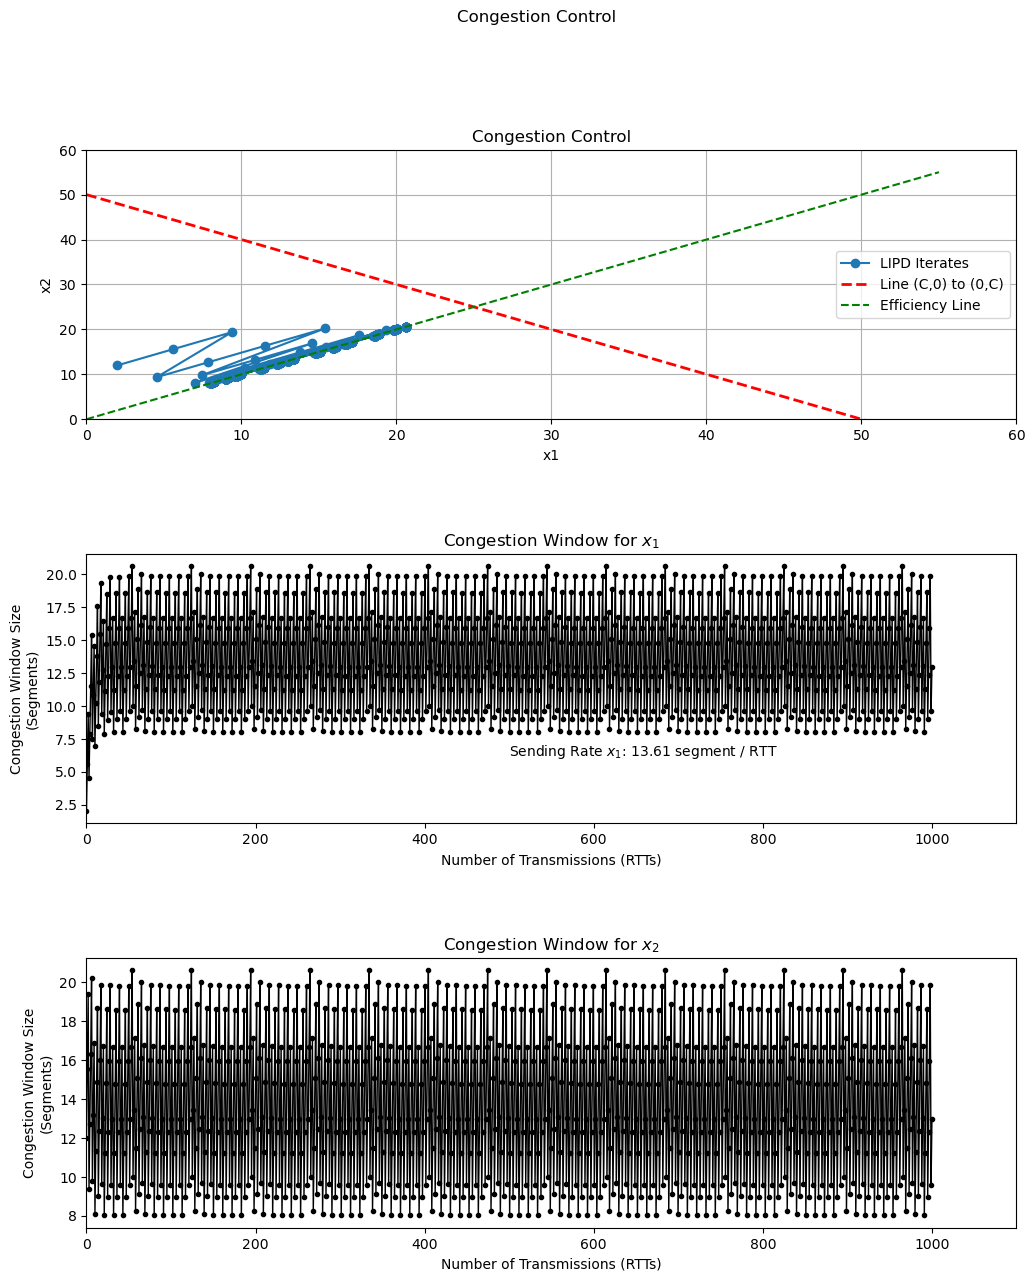

In [ ]:
congestion_control_simulation(C=50, x1=2, x2=12, alpha=1, beta=0.5, maxIterate=1000, mode='LIPD', x3=20)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def congestion_control_convergence(A, w0, max_iter=1000, tol=1e-6):
    """
    Function to demonstrate convergence of the system based on matrix A.
    
    Parameters:
    - A: The matrix governing the dynamics of the system.
    - w0: Initial window size vector.
    - max_iter: Maximum number of iterations.
    - tol: Convergence tolerance.
    
    Returns:
    - w: The converged window size vector.
    - history: List of window size vectors at each iteration.
    """
    w = np.array(w0)
    history = [w]
    
    for k in range(max_iter):
        # Update window sizes
        w_next = np.dot(A, w)
        
        # Check for convergence (stop if the difference is small)
        if np.linalg.norm(w_next - w) < tol:
            print(f"Convergence reached at iteration {k+1}")
            break
        
        # Append new window sizes to history
        history.append(w_next)
        w = w_next
    else:
        print(f"Maximum iterations reached. The system may not have converged.")
    
    return w, history

# Example matrix A (assuming three flows with similar behavior)
A = np.array([[0.5, 0, 0],
              [0, 0.5, 0],
              [0, 0, 0.5]])

# Initial window sizes for each flow
w0 = [2, 12, 5]  # Example initial window sizes

# Run the simulation and get the convergence result
w_converged, history = congestion_control_convergence(A, w0)

# Print the converged window sizes
print("Converged window sizes:", w_converged)

# Plot the evolution of window sizes over iterations
history = np.array(history)
plt.plot(history[:, 0], label='Flow 1')
plt.plot(history[:, 1], label='Flow 2')
plt.plot(history[:, 2], label='Flow 3')
plt.xlabel('Iterations')
plt.ylabel('Window Size')
plt.title('Convergence of TCP Dynamics (AIMD)')
plt.legend()
plt.show()
